Basic simple encoder decoder net using a LSTM.
Could be expanded to become a fully fledged translator.

This should be able to translate any set of token pairs. The first column should contain the input and the second column the target.

Improvement ideas:
* Use embeddings instead of one hot vector representation
* Do not pass the target to the seq2seq during evaluation
* Try using teacher forcing some % of the time
* Generates the max length sequence - maybe stop when hit <end>


In [71]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import csv
import matplotlib.pyplot as plt

In [55]:


filename = 'nums-big.txt'  # Replace with your file name

nums =[]
words=[]

with open(filename, 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        nums.append(row[0])
        words.append(row[1])

zipped = zip(nums, words)

pairs=[]
for item in zipped:
    n,w = item    
    pairs.append(["<s> "+n+" <e>","<s> "+w+" <e>"])
    
print("Num examples:", len(pairs))


# This class creates a word -> index mapping (e.g,. "dad" -> 5) and vice-versa 
# (e.g., 5 -> "dad") for each language,
class LanguageIndex():
    def __init__(self, lang):
        self.lang = lang
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()

        self.create_index()

    def create_index(self):
        for phrase in self.lang:
            self.vocab.update(phrase.split(' '))

        self.vocab = sorted(self.vocab)

        self.word2idx['<pad>'] = 0
        
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1

        for word, index in self.word2idx.items():
            self.idx2word[index] = word
            
def max_length(tensor):
    return max(len(t) for t in tensor)


import torch
from torch.nn.utils.rnn import pad_sequence

def load_dataset(pairs, num_examples):
    # pairs => already created cleaned input, output pairs

    # index language using the class defined above
    inp_lang = LanguageIndex(n for n, w in pairs)
    targ_lang = LanguageIndex(w for n, w in pairs)

    # Vectorize the input and target languages

    # Input sentences
    input_tensor = [torch.tensor([inp_lang.word2idx[s] for s in en.split(' ')], dtype=torch.long) for en, ma in pairs]

    # Target sentences
    target_tensor = [torch.tensor([targ_lang.word2idx[s] for s in ma.split(' ')], dtype=torch.long) for en, ma in pairs]

    # Calculate max_length of input and output tensor
    # Here, we'll set those to the longest sentence in the dataset
    max_length_inp, max_length_tar = max_length(input_tensor), max_length(target_tensor)

    # Padding the input and output tensor to the maximum length
    input_tensor = pad_sequence(input_tensor, batch_first=True, padding_value=0)
    input_tensor = input_tensor[:, :max_length_inp]

    target_tensor = pad_sequence(target_tensor, batch_first=True, padding_value=0)
    target_tensor = target_tensor[:, :max_length_tar]

    return input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_tar


input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_targ = load_dataset(pairs, len(pairs))

# One hot tensors -> could move to an embedding layer
oh_input = F.one_hot(input_tensor)
oh_target = F.one_hot(target_tensor)






Num examples: 40000


In [56]:
# PARAMETERS AND HYPERPARAMETERS 
INP_VOCAB_SIZE = len(inp_lang.word2idx)
TAR_VOCAB_SIZE = len(targ_lang.word2idx)
UNITS = 128 # #of units in the GRU - both encoder and decoder use this setting
INP_SEQ_LEN = max_length_inp
TAR_SEQ_LEN = max_length_targ
BATCH_SIZE = 1024

print(f"INPUT VOCAB SIZE:{INP_VOCAB_SIZE}, TARGET VOCAB SIZE: {TAR_VOCAB_SIZE}, UNITS: {UNITS},\
        INPUT SEQLEN:{INP_SEQ_LEN}, TARGET SEQ LENGTH: {TAR_SEQ_LEN}")


INPUT VOCAB SIZE:14, TARGET VOCAB SIZE: 34, UNITS: 128,        INPUT SEQLEN:8, TARGET SEQ LENGTH: 9


In [57]:


# Wrap the tensors in a TensorDataset and create the loader
dataset = TensorDataset(oh_input, oh_target)

# Split the dataset into train and eval subsets
train_size = int(0.9 * len(dataset))  # 90% for training
eval_size = len(dataset) - train_size  # 10% for evaluation
train_dataset, eval_dataset = torch.utils.data.random_split(dataset, [train_size, eval_size])

# Create DataLoaders for training and evaluation
dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
evalloader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=False)


# Encoder class 
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        # Encoder LSTM
        self.encoder_lstm = nn.LSTM(input_size, hidden_size, batch_first=True)   

    def forward(self, input_seq):
        # input_seq: [batch, seq, input_vocab]
        # outout : [batch, seq, units]
        # hidden: [1, seq, units] or [numlayers, seq, units]
        encoder_hidden, encoder_context = self.initialize(input_seq.shape[0])
        
        # Encoder
        encoder_output, (encoder_hidden, encoder_context) = self.encoder_lstm(input_seq, (encoder_hidden, encoder_context))
        return encoder_output, encoder_hidden, encoder_context
    
    def initialize(self, batchlen):
        return torch.zeros(1, batchlen, self.hidden_size), torch.zeros(1, batchlen, self.hidden_size)

# Decoder class
class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        # Decoder LSTM
        self.decoder_lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        # Linear layer to map hidden state to output
        self.fc = nn.Linear(hidden_size, output_size) 

    def forward(self, input_seq, hidden, context):
        # input_seq: [batch, seq (1), input_vocab]
        # outout : [batch, seq, units]
        # hidden: [1, seq, units] or [numlayers, seq, units]

        dec_output, (dec_hidden, dec_context) = self.decoder_lstm(input_seq, (hidden, context))
        # dec_output shape: 1, seq_len, hidden_size 
        
        dec_output = self.fc(dec_output)
        # output shape: 1, seq_len, output_size
        return dec_output, dec_hidden, dec_context

    
# The Seq2Seq model to connect the encoder and decoder
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    
    def forward(self, source, target, batchsize, training):
        # The sequence we produce will be stored in this tensor
        outputs = torch.zeros(batchsize, TAR_SEQ_LEN , TAR_VOCAB_SIZE)
        #print("outputs storage shape:", outputs.shape)
        
        # Call the encoder
        enc_output, enc_hidden, enc_context = self.encoder(source)
        # enc_output shape: [batch, seq, units]
        # hidden shape: [1, seq, units] or [numlayers, seq, units] 
        
        # Grab the last time slice of the state units
        hidden = enc_hidden
        context = enc_context
        # hidden shape: [1, seq, units]
        
        # Grab the first input to the Decoder which will be the <s> token
        output = F.one_hot(torch.tensor(targ_lang.word2idx['<s>']), TAR_VOCAB_SIZE).unsqueeze(0).float()
        output = output.unsqueeze(0)
        output = output.repeat(batchsize,1,1)
        
        # Generate the full sequence -> loop could be improved to a while loop
        for t in range(TAR_SEQ_LEN):
            #if(training):
            #    #Teacher forcing only if during training
            #    x = target[:,t,:].unsqueeze(1)
            #    #print("Train x shape:", x.shape)
            #else:
            x = output

            # Use previous hidden, cell as context from encoder at start
            output, hidden, context = self.decoder(x, hidden, context)
            # output shape: 1, seq_len, output_size
            
            # Store next output prediction
            outputs[:,t,:] = output.squeeze()           
            # outputs shape: seq_len, output_size
            
        return outputs

    
# Build the model and print out some stats    
encoder = Encoder(input_size=INP_VOCAB_SIZE, hidden_size=UNITS)
decoder = Decoder(input_size=TAR_VOCAB_SIZE, hidden_size=UNITS, output_size=TAR_VOCAB_SIZE)
model = Seq2Seq(encoder, decoder)

print(sum(p.numel() for p in encoder.parameters())/1e6, 'M parameters')
print(sum(p.numel() for p in decoder.parameters())/1e6, 'M parameters')


optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

0.073728 M parameters
0.088354 M parameters


Loss: 0.03975207358598709
Loss: 0.1595737189054489
Loss: 0.05631440132856369
Loss: 0.04444258660078049
Loss: 0.04633919894695282
Loss: 0.039530009031295776
Loss: 0.036661792546510696
Loss: 0.036950767040252686
Loss: 0.03238679841160774
Loss: 0.030313385650515556
Done!


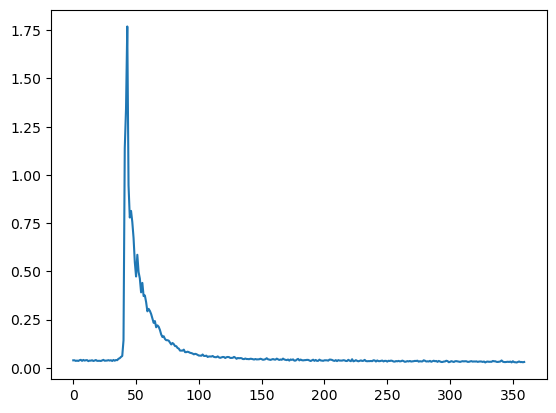

In [72]:
# Training phase

# for param_group in optimizer.param_groups:
#     param_group['lr'] = 0.01

bsize = 1

EPOCHS = 10
model.train()

step = 0
stepi = []
lossi = []

for e in range(EPOCHS):    
    
    for index, (inp, targ) in enumerate(dataloader):
        loss =0 
        bsize = inp.shape[0]
        
        output = model(inp.float(), targ.float(), bsize, 1)
        
        #print("model output:", output.shape)
        output = output.squeeze(1)
        targ = torch.argmax(targ, dim=2).squeeze(0)
        
        outr = output.view(-1,TAR_VOCAB_SIZE)
        tarr = targ.view(-1)
        loss += criterion(outr,tarr)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        stepi.append(step)
        lossi.append(loss.item())
        step += 1

        
    if(e%(EPOCHS/10)==0):
        print("Loss:", loss.item())

    # Training time ...

plt.plot(stepi,lossi)    

print("Done!")

In [73]:
# Evaluation phase
count = 0

for index, (inp, targ) in enumerate(evalloader):

    correct = 0 
    bsize = inp.shape[0]
    output = model(inp.float(), targ.float(), bsize, 0)

    #print("model output:", output.shape)
    output = output.squeeze(1)
    targ = torch.argmax(targ, dim=2).squeeze(0)

    outr = output.view(-1,TAR_VOCAB_SIZE)
    tarr = targ.view(-1)
    loss += criterion(outr,tarr)

    omax = torch.argmax(output, dim=2)
    imax = torch.argmax(inp, dim=2)

    outr = output.reshape(-1,TAR_VOCAB_SIZE)
    tarr = targ.view(-1)

    for b in range(bsize):

        print("\nI: ", end="")
        for i in range(INP_SEQ_LEN):
            print(inp_lang.idx2word[imax[b][i].item()] + " ", end='')

        print("\nP: ", end="")
        pout = ""
        for t in range(TAR_SEQ_LEN):
            pout += targ_lang.idx2word[omax[b][t].item()] +" "
        print(pout + " ", end="")

        label = ""
        print("\nT: ", end="")
        for s in range(TAR_SEQ_LEN):
            label += targ_lang.idx2word[targ[b][s].item()] + " "
        print(label + " ", end="")
                                      
        if( pout == label ):
            correct += 1
            print(" Ding!", end="")

        print()

print(f"\n\n Correct: {correct}, Total: {bsize}, Acuuracy: {correct/bsize}")


I: <s> 3 4 0 1 0  <e> 
P: <s> thirty four thousand ten <e> <pad> <pad> <pad>  
T: <s> thirty four thousand ten <e> <pad> <pad> <pad>   Ding!

I: <s> 2 5 3 2  <e> <pad> 
P: <s> two thousand five hundred thirty two <e> <pad>  
T: <s> two thousand five hundred thirty two <e> <pad>   Ding!

I: <s> 2 8 0 5 8  <e> 
P: <s> twenty eight thousand eighty eight <e> <pad> <pad>  
T: <s> twenty eight thousand fifty eight <e> <pad> <pad>  

I: <s> 4 1 6 5  <e> <pad> 
P: <s> four thousand one hundred sixty five <e> <pad>  
T: <s> four thousand one hundred sixty five <e> <pad>   Ding!

I: <s> 3 3 1 5 4  <e> 
P: <s> thirty three thousand one hundred fifty four <e>  
T: <s> thirty three thousand one hundred fifty four <e>   Ding!

I: <s> 4 0 2 9  <e> <pad> 
P: <s> four thousand twenty nine <e> <pad> <pad> <pad>  
T: <s> four thousand twenty nine <e> <pad> <pad> <pad>   Ding!

I: <s> 3 2 5 5 0  <e> 
P: <s> thirty two thousand five hundred fifty  <e>  
T: <s> thirty two thousand five hundred fifty  <e>  


I: <s> 2 9 6 7 2  <e> 
P: <s> twenty nine thousand six hundred seventy two <e>  
T: <s> twenty nine thousand six hundred seventy two <e>   Ding!

I: <s> 3 7 9 0  <e> <pad> 
P: <s> three thousand seven hundred ninety  <e> <pad>  
T: <s> three thousand seven hundred ninety  <e> <pad>   Ding!

I: <s> 6 3 8 4  <e> <pad> 
P: <s> six thousand three hundred eighty four <e> <pad>  
T: <s> six thousand three hundred eighty four <e> <pad>   Ding!

I: <s> 6 0 8 2  <e> <pad> 
P: <s> six thousand eighty two <e> <pad> <pad> <pad>  
T: <s> six thousand eighty two <e> <pad> <pad> <pad>   Ding!

I: <s> 3 6 8 0 1  <e> 
P: <s> thirty six thousand eight hundred one <e> <pad>  
T: <s> thirty six thousand eight hundred one <e> <pad>   Ding!

I: <s> 6 8 0 9  <e> <pad> 
P: <s> six thousand eight hundred nine <e> <pad> <pad>  
T: <s> six thousand eight hundred nine <e> <pad> <pad>   Ding!

I: <s> 3 7 1 3 6  <e> 
P: <s> thirty seven thousand one hundred thirty six <e>  
T: <s> thirty seven thousand one hundred


I: <s> 2 7 3 9  <e> <pad> 
P: <s> two thousand seven hundred thirty nine <e> <pad>  
T: <s> two thousand seven hundred thirty nine <e> <pad>   Ding!

I: <s> 6 2 4  <e> <pad> <pad> 
P: <s> six hundred twenty four <e> <pad> <pad> <pad>  
T: <s> six hundred twenty four <e> <pad> <pad> <pad>   Ding!

I: <s> 7 9 3  <e> <pad> <pad> 
P: <s> seven hundred ninety three <e> <pad> <pad> <pad>  
T: <s> seven hundred ninety three <e> <pad> <pad> <pad>   Ding!

I: <s> 4 8 8 1  <e> <pad> 
P: <s> four thousand eight hundred eighty one <e> <pad>  
T: <s> four thousand eight hundred eighty one <e> <pad>   Ding!

I: <s> 2 4 4 3 9  <e> 
P: <s> twenty four thousand four hundred thirty nine <e>  
T: <s> twenty four thousand four hundred thirty nine <e>   Ding!

I: <s> 3 6 4 2 0  <e> 
P: <s> thirty six thousand four hundred twenty  <e>  
T: <s> thirty six thousand four hundred twenty  <e>   Ding!

I: <s> 8 6 9 5  <e> <pad> 
P: <s> eight thousand six hundred ninety five <e> <pad>  
T: <s> eight thousand six 


I: <s> 2 3 4 9 5  <e> 
P: <s> twenty three thousand four hundred ninety five <e>  
T: <s> twenty three thousand four hundred ninety five <e>   Ding!

I: <s> 1 9 3 5 6  <e> 
P: <s> nineteen thousand three hundred fifty six <e> <pad>  
T: <s> nineteen thousand three hundred fifty six <e> <pad>   Ding!

I: <s> 4 0 6 4  <e> <pad> 
P: <s> four thousand forty four <e> <pad> <pad> <pad>  
T: <s> four thousand sixty four <e> <pad> <pad> <pad>  

I: <s> 2 7 9 9 4  <e> 
P: <s> twenty seven thousand nine hundred ninety four <e>  
T: <s> twenty seven thousand nine hundred ninety four <e>   Ding!

I: <s> 1 6 7 1  <e> <pad> 
P: <s> one thousand six hundred seventy one <e> <pad>  
T: <s> one thousand six hundred seventy one <e> <pad>   Ding!

I: <s> 2 5 0 1 8  <e> 
P: <s> twenty five thousand eighty <e> <pad> <pad> <pad>  
T: <s> twenty five thousand eighteen <e> <pad> <pad> <pad>  

I: <s> 3 1 6 0 7  <e> 
P: <s> thirty one thousand six hundred seven <e> <pad>  
T: <s> thirty one thousand six hundre